Adaptive threshold: 1.15e+00 (99.0th percentile)
Identifying spectral peaks with threshold: 1.15e+00
Spectrum values: min=1.86e-11, max=5.17e+00, mean=1.04e-01
Identified 2 spectral peaks
Generating mask from ICOD...
  ICOD propagation converged after 3 iterations
Calculating distances between peaks...
Calculating peak spreading...
Checking for overlapping systems (merge_factor=0.5)...
Number of masks: 2
[DEBUG] Sum of partition energies: 0.177882
[DEBUG] Expected total: 0.177882
Total spectrum energy: 0.169230
Sum of partitioned energies: 0.177882

 SPECTRAL PARTITIONING - PROCESS SUMMARY
🔍 Spectral peaks initially identified: 2
🔗 After merging nearby systems: 2 partition(s)

 PARTITIONING RESULTS
Number of partitions found: 2
──────────────────────────────────────────────────────────────────────

Partition 1:
  Hs = 1.33 m
  Tp = 8.76 s
  Dp = 302°
  Energy: 0.1101 m²
  Energy fraction: 65.1%

Partition 2:
  Hs = 1.04 m
  Tp = 15.52 s
  Dp = 68°
  Energy: 0.0678 m²
  Energy fraction:

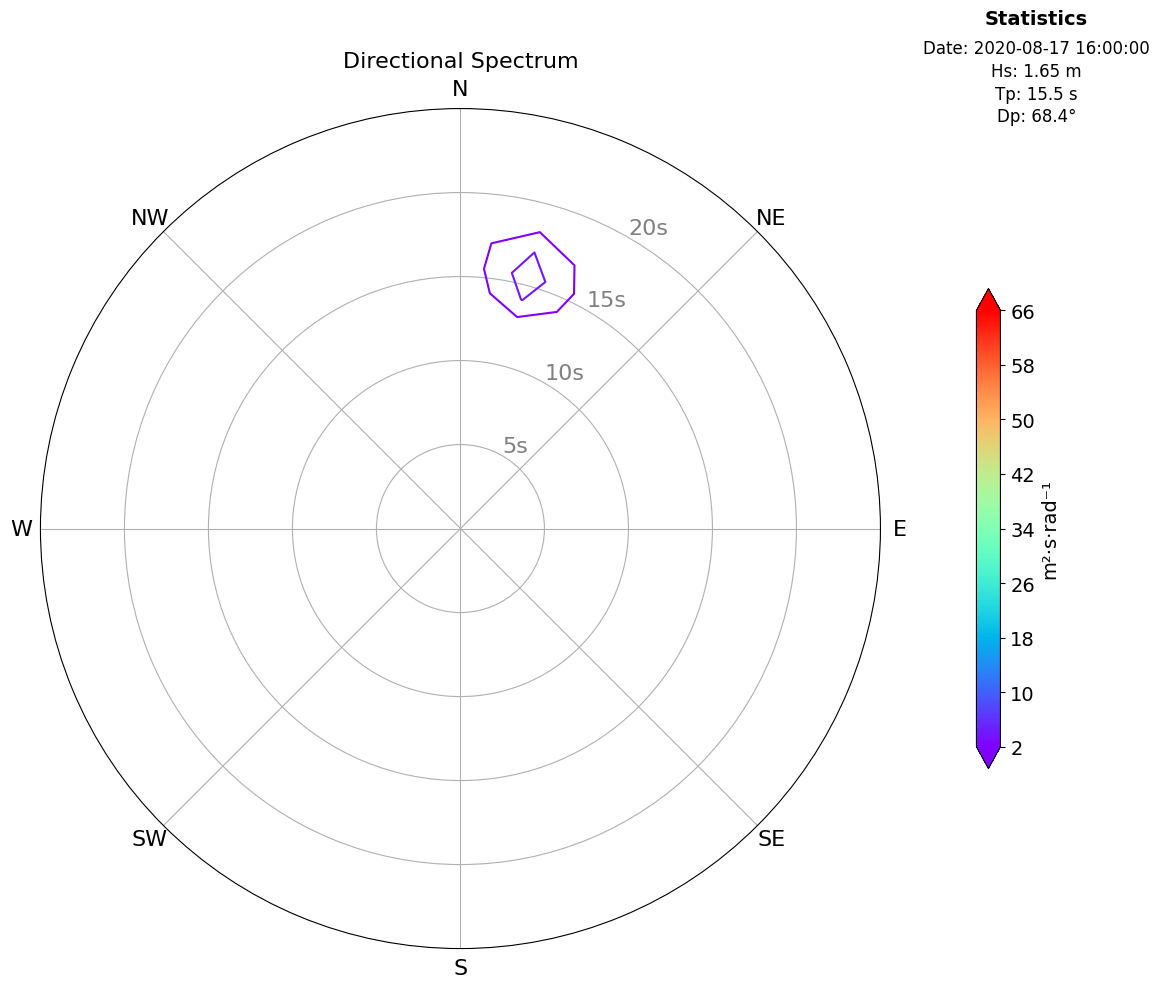

In [20]:
# Imports
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import from wasp package
from wasp.io_ww3 import find_closest_time, load_ww3_spectrum
from wasp.wave_params import calculate_wave_parameters
from wasp.partition import partition_spectrum
from wasp.plotting import plot_directional_spectrum


# WW3 file
file_path='/Users/jtakeo/data/ww3/ndbc/ww3_51004.nc'
itime=5527
selected_time = pd.to_datetime(xr.open_dataset(file_path).time[itime].values)

ds = xr.open_dataset(file_path)
spec = ds.efth[itime,0,:,:].values
lon = ds.longitude.values[0]
lat = ds.latitude.values[0]

E2d = ds.efth[itime,0,:,:].values
freq = ds.frequency.values
dirs = ds.direction.values
dirs_rad = np.radians(dirs)

# Apply partitioning with WW3-specific parameters
# WW3 has moderate resolution, so we use:
# - Moderate threshold (99.0%) balanced for model data
# - Balanced merge (0.5) for typical conditions
# Models can represent multiple systems (swell + wind sea)

results = partition_spectrum(
    E2d, freq, dirs_rad,
    threshold_mode='adaptive',
    threshold_percentile=99.0,  # WW3: Moderate threshold for model data
    merge_factor=0.5,           # WW3: Balanced merging
    max_partitions=5            # WW3: Models can have 2-5 systems
)

if results is None:
    print("No spectral peaks identified!")
else:
    # Partitioning process information
    n_peaks_initial = len(results['peaks'])
    
    # Count how many partitions really have significant energy (> 1% of total for WW3)
    min_energy_threshold = 0.01 * results['total_m0']  # 1% of total energy
    n_partitions_final = 0
    for i in range(1, len(results['Hs'])):
        if results['energy'][i] > min_energy_threshold:
            n_partitions_final += 1
    
    print("\n" + "="*70)
    print(" SPECTRAL PARTITIONING - PROCESS SUMMARY")
    print("="*70)
    print(f"🔍 Spectral peaks initially identified: {n_peaks_initial}")
    print(f"🔗 After merging nearby systems: {n_partitions_final} partition(s)")
    print("="*70)
    
    print("\n" + "="*70)
    print(" PARTITIONING RESULTS")
    print("="*70)
    print(f"Number of partitions found: {n_partitions_final}")
    print("─"*70)
    
    # Display information for each partition that actually exists
    partition_count = 0
    for i in range(1, len(results['Hs'])):
        if results['energy'][i] > min_energy_threshold:  # Only significant energy
            partition_count += 1
            print(f"\nPartition {partition_count}:")
            print(f"  Hs = {results['Hs'][i]:.2f} m")
            print(f"  Tp = {results['Tp'][i]:.2f} s")
            print(f"  Dp = {results['Dp'][i]:.0f}°")
            print(f"  Energy: {results['energy'][i]:.4f} m²")
            print(f"  Energy fraction: {(results['energy'][i]/results['total_m0'])*100:.1f}%")
    
    print("\n" + "─"*70)
    print(f"Integrated total:")
    print(f"  Hs = {results['total_Hs']:.2f} m")
    print(f"  Tp = {results['total_Tp']:.2f} s")
    print(f"  Dp = {results['total_Dp']:.0f}°")
    print("="*70)

# Calculate Hs, Tp, Dp using trapezoidal integration
hs, tp, dp, m0, delf, ddir, i_peak, j_peak = calculate_wave_parameters(E2d, freq, dirs_rad)


# Plot do espectro direcional 2D em coordenadas polares
fig, ax = plot_directional_spectrum(
    E2d, 
    freq, 
    dirs,
    selected_time=selected_time,
    hs=hs,
    tp=tp,
    dp=dp
)

plt.show()


/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_51920/3642597063.py:31: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax2.contour(theta, r, E_part, levels=levels_part,


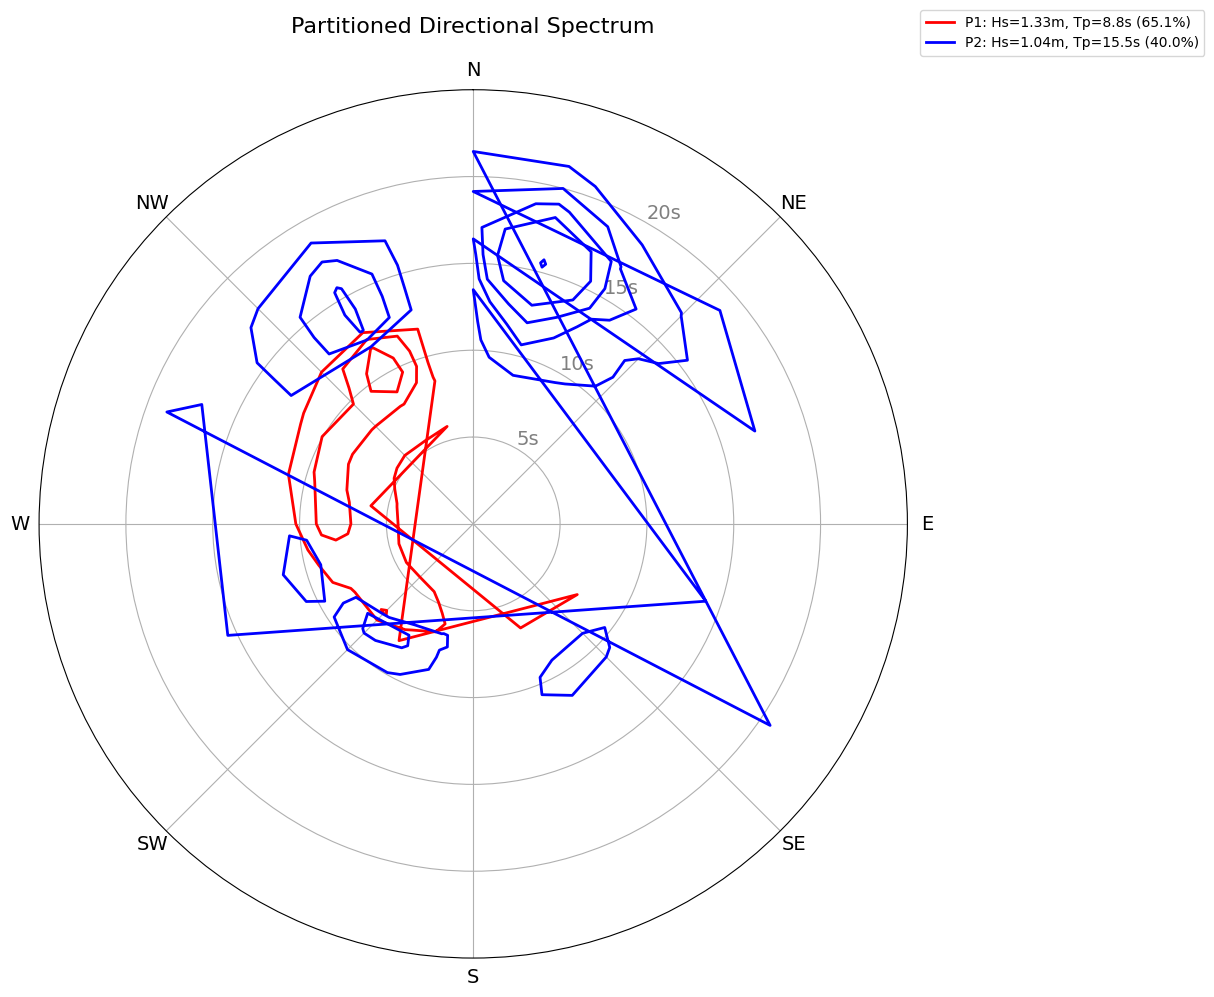

In [21]:
# Plot das partições individuais no espectro polar
fig2, ax2 = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Preparar dados
freq_plot = np.asarray(freq).flatten()
dirs_plot = np.asarray(dirs).flatten()
dirs_rad_plot = np.radians(dirs_plot)

# Converter para período
with np.errstate(divide='ignore', invalid='ignore'):
    period = np.where(freq_plot > 0, 1.0 / freq_plot, 0)

# Criar meshgrid
theta, r = np.meshgrid(dirs_rad_plot, period)

# Cores para cada partição
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
min_energy_threshold = 0.01 * results['total_m0']  # 1% para mostrar todas as partições significativas

# Plotar contornos de cada partição
partition_count = 0
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > min_energy_threshold:
        # Criar espectro apenas para esta partição
        E_part = np.zeros_like(E2d)
        mask = (results['mask'] == i)
        E_part[mask] = E2d[mask]
        
        # Plotar contorno
        levels_part = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
        cs = ax2.contour(theta, r, E_part, levels=levels_part, 
                        colors=colors[partition_count % len(colors)], linewidths=2,
                        label=f'Partition {partition_count+1}')
        
        partition_count += 1

# Configurar eixos
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_rticks([5, 10, 15, 20])
ax2.set_yticklabels(['5s', '10s', '15s', '20s'], color='gray', fontsize=12)
ax2.set_rlim(0, 25)
ax2.set_rlabel_position(30)
ax2.tick_params(axis='y', colors='gray', labelsize=14)

ticks = ['N','NE','E','SE','S','SW','W','NW']
tick_angles = np.deg2rad(np.linspace(0, 315, 8))
ax2.set_xticks(tick_angles)
ax2.set_xticklabels(ticks, fontsize=14)

ax2.set_title('Partitioned Directional Spectrum', fontsize=16, pad=20)

# Legenda
from matplotlib.lines import Line2D
legend_elements = []
partition_count = 0
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > min_energy_threshold:
        pct = (results['energy'][i]/results['total_m0'])*100
        label = f'P{partition_count+1}: Hs={results["Hs"][i]:.2f}m, Tp={results["Tp"][i]:.1f}s ({pct:.1f}%)'
        legend_elements.append(Line2D([0], [0], color=colors[partition_count % len(colors)], lw=2, label=label))
        partition_count += 1

ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=10)

plt.tight_layout()
plt.show()


In [22]:
# Diagnóstico: ver todas as energias das partições para decidir o threshold
print("\n" + "="*70)
print(" DIAGNÓSTICO - TODAS AS PARTIÇÕES E SUAS ENERGIAS")
print("="*70)
print(f"Energia total (m0): {results['total_m0']:.6f} m²")
print(f"Threshold atual (1%): {0.01 * results['total_m0']:.6f} m²")
print("\n" + "─"*70)

# Mostrar TODAS as partições, mesmo as com energia muito baixa
all_partitions = []
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > 0:  # Qualquer energia > 0
        percentage = (results['energy'][i] / results['total_m0']) * 100
        all_partitions.append({
            'id': i,
            'energy': results['energy'][i],
            'percentage': percentage,
            'Hs': results['Hs'][i]
        })

# Ordenar por energia (maior primeiro)
all_partitions.sort(key=lambda x: x['energy'], reverse=True)

print(f"Total de partições com energia > 0: {len(all_partitions)}\n")

for idx, part in enumerate(all_partitions, 1):
    marker = "★" if idx == 1 else " "
    print(f"{marker} Partição {idx} (ID={part['id']}):")
    print(f"    Energia: {part['energy']:.6f} m² ({part['percentage']:.2f}%)")
    print(f"    Hs: {part['Hs']:.3f} m")

print("\n" + "─"*70)
print("RECOMENDAÇÕES DE THRESHOLD:")

# Calcular thresholds para mostrar 1, 2, 3 sistemas
if len(all_partitions) >= 2:
    # Threshold para mostrar apenas 1 sistema = energia da 2ª partição
    threshold_1_system = all_partitions[1]['energy']
    threshold_1_pct = all_partitions[1]['percentage']
    print(f"  Para 1 sistema:  threshold > {threshold_1_pct:.2f}% ({threshold_1_system:.6f} m²)")

if len(all_partitions) >= 3:
    threshold_2_systems = all_partitions[2]['energy']
    threshold_2_pct = all_partitions[2]['percentage']
    print(f"  Para 2 sistemas: threshold > {threshold_2_pct:.2f}% ({threshold_2_systems:.6f} m²)")

if len(all_partitions) >= 4:
    threshold_3_systems = all_partitions[3]['energy']
    threshold_3_pct = all_partitions[3]['percentage']
    print(f"  Para 3 sistemas: threshold > {threshold_3_pct:.2f}% ({threshold_3_systems:.6f} m²)")

print("="*70)



 DIAGNÓSTICO - TODAS AS PARTIÇÕES E SUAS ENERGIAS
Energia total (m0): 0.169230 m²
Threshold atual (1%): 0.001692 m²

──────────────────────────────────────────────────────────────────────
Total de partições com energia > 0: 2

★ Partição 1 (ID=1):
    Energia: 0.110111 m² (65.07%)
    Hs: 1.327 m
  Partição 2 (ID=2):
    Energia: 0.067771 m² (40.05%)
    Hs: 1.041 m

──────────────────────────────────────────────────────────────────────
RECOMENDAÇÕES DE THRESHOLD:
  Para 1 sistema:  threshold > 40.05% (0.067771 m²)


# Saving results

In [23]:
import pandas as pd

# Define output directory and create if it doesn't exist
output_dir = '../data/sar/partition'
os.makedirs(output_dir, exist_ok=True)

# Reference
referencia = 51  # neste exemplo, que esta relacionado ao ww3

# Create filename with timestamp and index
output_filename = f'partition_ww3_ref_{referencia}_{selected_time}.csv'
output_path = os.path.join(output_dir, output_filename)



# Get moments from results
moments = results['moments']
m0_total = moments['total'][0]
m1_total = moments['total'][1]
m2_total = moments['total'][2]

# Prepare data dictionary
data = {
    'reference_id': referencia,
    'obs_time': selected_time,
    'longitude': float(lon),
    'latitude': float(lat),
    'source_file': os.path.basename(file_path),
    
    # Total spectrum
    'total_energy': results['total_m0'],
    'total_Hs': results['total_Hs'],
    'total_Tp': results['total_Tp'],
    'total_Dp': results['total_Dp'],
    'total_m0': m0_total,
    'total_m1': m1_total,
    'total_m2': m2_total,
}

# Add partition data (up to 3 partitions)
for p in range(1, 4):
    if p < len(results['Hs']) and results['energy'][p] > min_energy_threshold:
        data[f'P{p}_energy'] = results['energy'][p]
        data[f'P{p}_Hs'] = results['Hs'][p]
        data[f'P{p}_Tp'] = results['Tp'][p]
        data[f'P{p}_Dp'] = results['Dp'][p]
        data[f'P{p}_m0'] = moments['m0'][p]
        data[f'P{p}_m1'] = moments['m1'][p]
        data[f'P{p}_m2'] = moments['m2'][p]
    else:
        data[f'P{p}_energy'] = 0.0
        data[f'P{p}_Hs'] = 0.0
        data[f'P{p}_Tp'] = 0.0
        data[f'P{p}_Dp'] = 0.0
        data[f'P{p}_m0'] = 0.0
        data[f'P{p}_m1'] = 0.0
        data[f'P{p}_m2'] = 0.0

# Create DataFrame
df_results = pd.DataFrame([data])

# Save to CSV
df_results.to_csv(output_path, index=False, float_format='%.6f')

print(f"\n✓ Results saved to: {output_path}")
print(f"\nColumns in CSV: {list(df_results.columns)}")
print(f"\nPreview:")
print(df_results.T)



✓ Results saved to: ../data/sar/partition/partition_ww3_ref_51_2020-08-17 16:00:00.csv

Columns in CSV: ['reference_id', 'obs_time', 'longitude', 'latitude', 'source_file', 'total_energy', 'total_Hs', 'total_Tp', 'total_Dp', 'total_m0', 'total_m1', 'total_m2', 'P1_energy', 'P1_Hs', 'P1_Tp', 'P1_Dp', 'P1_m0', 'P1_m1', 'P1_m2', 'P2_energy', 'P2_Hs', 'P2_Tp', 'P2_Dp', 'P2_m0', 'P2_m1', 'P2_m2', 'P3_energy', 'P3_Hs', 'P3_Tp', 'P3_Dp', 'P3_m0', 'P3_m1', 'P3_m2']

Preview:
                                0
reference_id                   51
obs_time      2020-08-17 16:00:00
longitude                  -152.5
latitude                17.530001
source_file          ww3_51004.nc
total_energy              0.16923
total_Hs                 1.645503
total_Tp                15.523031
total_Dp                68.391106
total_m0                 0.177882
total_m1                 0.151046
total_m2                 0.161476
P1_energy                0.110111
P1_Hs                    1.327322
P1_Tp            

/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_51920/3760525046.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'longitude': float(lon),
/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_51920/3760525046.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'latitude': float(lat),
